### KRX 데이터정보시스템
투자자별 매매동향

In [1]:
from selenium import webdriver as wd
from selenium.webdriver import ActionChains # scroll down 사용하기 위하여 선서
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs

import datetime, time
from datetime import date

import pandas as pd
import requests
import time
import os, sys

In [2]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [3]:
# !pip install chromedriver_autoinstaller

import chromedriver_autoinstaller

driver_name = chromedriver_autoinstaller.install()  # Check if the current version of chromedriver exists
                                      # and if it doesn't exist, download it automatically,
                                      # then add chromedriver to path
time.sleep(1)

In [4]:
driver = wd.Chrome(driver_name)

In [5]:
# driver.set_window_position(-10000,0) # hide windows
main_url = 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203'
driver.get(main_url)
time.sleep(2)

In [6]:
company_name = ['005930/삼성전자', '005380/현대차', '035420/NAVER', '033780/KT&G']
company_code = {'sec': '005930', 'hyunmotor': '005380', 'naver': '035420', 'ktng': '033780'}
company_name = ['005380/현대차']
company_code = {'hyunmotor': '005380'}

company_match = {'005930': '005930/삼성전자', '005380': '005380/현대차',
                 '035420': '035420/NAVER', '033780': '033780/KT&G'}

In [7]:
start_date = '2022-01-01'
today = datetime.date.today()
today = today.strftime('%Y-%m-%d')
end_date = today
end_date = '2022-03-01'

In [8]:
column_name = ['financial', 'insurance', 'invtrust', 'privequity', 'bank', 'financeetc', 'pension',
              'institution', 'corporateetc', 'retail', 'foreigner', 'foreigneretc', 'total' ]

In [9]:
# Message: element not interactable Error 방지용. 클릭하기 위하여는 그 위치가 클릭할 수 있게 노출되어 있어야 함
# 투자자별 거래실적 버튼이 위치한 곳으로 화면 scroll 

# id가 jsOpenView_1 인 element 를 찾음
stop_tag = driver.find_element_by_id('jsOpenView_1')

# jsOpenView_1 element 까지 스크롤
action = ActionChains(driver)
action.move_to_element(stop_tag).perform()

In [10]:
# xps = '/html/body/div[2]/section[2]/section/section/div/div/div[1]/div[1]/div[5]/button[1]'
# driver.find_element_by_xpath(xps).click() 
# # 창이 스크롤 다운할 필요가 없어야 하게 충분히 커야 함. 
# # 그렇지 않으면 Message: element not interactable Error 발생

In [11]:
# 투자자별 거래 실적 버튼 클릭
driver.find_element_by_id('jsOpenView_1').click()
# interactive error 방지 error solution
time.sleep(2)

In [12]:
# 백만원 단위 표시 선정
css_sel = '#MDCSTAT023_FORM > div.CI-MDI-UNIT-WRAP > div > p:nth-child(2) > select.CI-MDI-UNIT-MONEY > option:nth-child(3)'
driver.find_element_by_css_selector(css_sel).click()
time.sleep(2)

In [13]:
# driver.find_element_by_id('jsOpenView_1').send_keys(Keys.ENTER)
# # interactive error 방지 error solution

In [14]:
def date_set(datei):
# end_date를 먼저 입력하고 start date 입력. 반대로 하면 start date가 이전날짜로  reset되어짐
    driver.find_element_by_id('endDd').clear()
    driver.find_element_by_id('endDd').send_keys(datei)
    time.sleep(1)
    driver.find_element_by_id('strtDd').clear()
    driver.find_element_by_id('strtDd').send_keys(datei)
    time.sleep(1)
    return

In [15]:
def push_button_1(): # 조회 button push
    xp = '/html/body/div[2]/section[2]/section/section/div/div[2]/form/div[1]/div/a' 
    # use full xpath to avoid 'Message: element not interactable' Error
    driver.find_element_by_xpath(xp).click()
    time.sleep(1) # 여유시간 배분
    css_sel = '#jsMdiContent > div.CI-MDI-CONTENT.active \
           > div.CI-GRID-AREA.CI-GRID-ON-WINDOWS.CI-GRID-CLICKED \
           > div.loading-bar-overlay'
    element = WebDriverWait(driver, 10).until(EC.invisibility_of_element_located((By.CSS_SELECTOR, css_sel)))
    time.sleep(1) # 여유시간 배분

In [16]:
# 아래그림: upload 중이라는 indicator창 내용 (upload완료시 사라짐).
# 마지막 부분 div.loading-bar-overlay를 기준으로 위 코드와 같이 지정하면 온전히 데이터를 취득할 수 있음

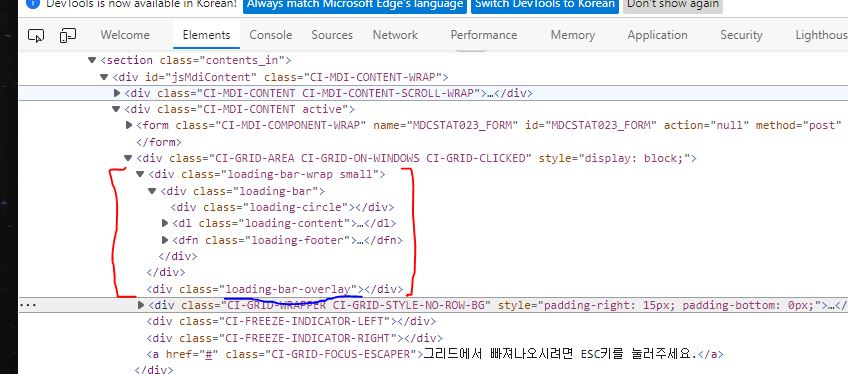

In [17]:
index_name = ['investor', 'sell_quantity', 'buy_quantity', 'pure_buy_quantiry', 'sell', 'buy', 'pure_buy']
def get_year_data(date_range):
    df_org = None
    for datei in date_range:
        date_set(datei)
        push_button_1()
        df = pd.read_html(driver.page_source, 
                          attrs={"class": "CI-GRID-BODY-TABLE"}, flavor=["lxml", "bs4"])[0]
        df.columns = index_name
        df_new = df[['investor', 'pure_buy']]
        df_new.set_index('investor', inplace=True)
        dft = df_new.T
        dft.columns = column_name
        dft.insert(0, "date", datetime.datetime.strptime(datei, "%Y%m%d"))
        dft.reset_index(drop=True, inplace=True)
        if df_org is None:
            df_org = dft.copy()
            continue
        df_org = df_org.append(dft, ignore_index=True)
        
    return df_org

In [18]:
def get_data_company(com_name, start_date, end_date):
    
    # 회사이름 입력 Q 버튼
    driver.find_element_by_css_selector('#btnisuCd_finder_stkisu0_1').click()
    time.sleep(2)

    # pop up된 입력창에서 회사이름 입력
    driver.find_element_by_id('searchText__finder_stkisu0_1').clear()
    time.sleep(1)
    driver.find_element_by_id('searchText__finder_stkisu0_1').send_keys(com_name)
    time.sleep(2)

    # 검색 버튼 푸시
    driver.find_element_by_css_selector('#searchBtn__finder_stkisu0_1').click()
    time.sleep(2)

    # 테이블에서 최종 선택
    css_sel = '#jsGrid__finder_stkisu0_1 > tbody > tr:nth-child(1) > td:nth-child(1)'
    driver.find_element_by_css_selector(css_sel).click()
    time.sleep(2)
    
    date_range = convert_date(start_date, end_date)
    return get_year_data(date_range)

In [19]:
def convert_date(start_date, end_date):
    date_range_ts = pd.date_range(start=start_date, end=end_date)
    date_range = []
    for x in date_range_ts:
        date_range.append(datetime.datetime.strftime(x, "%Y%m%d"))
    return date_range

In [20]:
def append_data(company_code, company_match, com_df):
    for key, val in company_code.items():
        filename = 'data/{}_{}.csv'.format('data', key)
        df_company = pd.read_csv(filename)
        df_company['date'] = df_company['date'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))
        df_company.set_index('date', inplace=True)

        df = com_df[company_match[val]]
        df_select = df[['date', 'financial', 'insurance', 'invtrust', 'privequity', 'bank', 'financeetc', 
                        'pension', 'institution', 'corporateetc', 'retail', 'foreigner', 'foreigneretc' ]]
        df_select.set_index('date', inplace=True)
    #     df_company.update(df_select, overwrite=False)
        df_company.update(df_select)
        df_company.reset_index(inplace=True)
        df_company.to_csv(filename, index=False)
        return df_company

In [21]:
# 메인 데이터 취득
com_df = {}

for com_name in company_name:
    com_df[com_name] = get_data_company(com_name, start_date, end_date)
    
df = append_data(company_code, company_match, com_df)

In [22]:
# for key, val in company_code.items():
#     filename = 'data/{}_{}.csv'.format('data', key)
#     df_company = pd.read_csv(filename)
#     df_company['date'] = df_company['date'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))
#     df_company.set_index('date', inplace=True)
    
#     df = com_df[company_match[val]]
#     df_select = df[['date', 'financial', 'insurance', 'invtrust', 'privequity', 'bank', 'financeetc', 
#                     'pension', 'institution', 'corporateetc', 'retail', 'foreigner', 'foreigneretc' ]]
#     df_select.set_index('date', inplace=True)
# #     df_company.update(df_select, overwrite=False)
#     df_company.update(df_select)
#     df_company.reset_index(inplace=True)
#     df_company.to_csv(filename, index=False)

In [23]:
driver.close()
driver.quit()

#### 아래 참고

In [24]:
'''
개인 : 일반인이 주식을 매매
외국인 : 주로 외국계 증권사
기관 : 개인을 제외한 투자자
금융투자 : 증권사, 자산운용사 등이 회사자산을 이용하여 투자할 경우
투자신탁 : 증권사, 자산운용사 등이 고객의 자산을 이용하여 투자, 펀드 등
사모펀드 : 고객의 자산을 이용하여 투자.
은행 : 고객의 예금을 운용하여 투자
보험 : 고객의 보험금을 운용하여 투자
연기금 : 각종 연금, 공제회 기금등을 직접 운용하여 투자
국가 : 우체국, 보험공사, 주택공사등 공공기관
기타금융 : 상호저축은행 등
기타법인 : 투자기관이 아닌 법인이 투자할 경우, 자사주 매입등
기타외국인 : 국내에 6개월 이상 거주하는 외국인. 주로 개인투자자
'''

'\n개인 : 일반인이 주식을 매매\n외국인 : 주로 외국계 증권사\n기관 : 개인을 제외한 투자자\n금융투자 : 증권사, 자산운용사 등이 회사자산을 이용하여 투자할 경우\n투자신탁 : 증권사, 자산운용사 등이 고객의 자산을 이용하여 투자, 펀드 등\n사모펀드 : 고객의 자산을 이용하여 투자.\n은행 : 고객의 예금을 운용하여 투자\n보험 : 고객의 보험금을 운용하여 투자\n연기금 : 각종 연금, 공제회 기금등을 직접 운용하여 투자\n국가 : 우체국, 보험공사, 주택공사등 공공기관\n기타금융 : 상호저축은행 등\n기타법인 : 투자기관이 아닌 법인이 투자할 경우, 자사주 매입등\n기타외국인 : 국내에 6개월 이상 거주하는 외국인. 주로 개인투자자\n'

driver.find_element(By.CSS_SELECTOR, "#payment > div  > div > iframe")
and 
driver.switch_to.frame(iframe)

In [25]:
# Message: element not interactable Error 도움말
# https://stackoverflow.com/questions/56194094/how-to-fix-this-issue-element-not-interactable-selenium-python